# About Dataset:
> https://www.kaggle.com/datasets/berkerisen/wind-turbine-scada-dataset.
> In Wind Turbines, Scada Systems measure and save data's like wind speed, wind direction, generated power etc. for 10 minutes intervals. This file was taken from a wind turbine's scada system that is working and generating power in Turkey.
# Object: 
> Create a model with high accuracy to predict/optimize output power for a turbine

# First: Feature Engineering

In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv("/kaggle/input/wind-turbine-scada-dataset/T1.csv")

In [ ]:
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [ ]:
# view null cells
df[df.isnull().any(axis=1)]

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)


In [ ]:
#describe dataset
df.describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776283,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


In [ ]:
# Replce -ve "LV ActivePower (kW)" values with zero

df["LV ActivePower (kW)"] = df["LV ActivePower (kW)"].apply(lambda x: 0 if x < 0 else x)
df["LV ActivePower (kW)"].describe()

count    50530.000000
mean      1307.684699
std       1312.458876
min          0.000000
25%         50.677890
50%        825.838074
75%       2482.507568
max       3618.732910
Name: LV ActivePower (kW), dtype: float64

# Let's Begin!
we need to **discover hidden patterns** in this dataset, so let's create some new features(variables).

## Date/Time Column
**First, reformat date/time**, **to create what?**:
- Month column: capture monthly variations.
- Day or night?: as wind speed may vary at these times.
- Day column: capture week variance
- Season column: capture sesons variations

**Anyway**: we will analyze the importance of each of these feature relevance to the target later, so worying about computational cost is not relevant now.

In [ ]:

# Convert "Date/Time" column to datetime format
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format="%d %m %Y %H:%M")

# Extract week, month, and hour information
df['Week'] = df['Date/Time'].dt.isocalendar().week
df['Month'] = df['Date/Time'].dt.month
df['Hour'] = df['Date/Time'].dt.hour

# Define function to get season based on month
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

df['Season'] = df['Month'].apply(get_season)

# Display the updated DataFrame
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Week,Month,Hour,Season
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,1,1,0,Winter
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,1,1,0,Winter
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,1,1,0,Winter
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,1,1,0,Winter
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,1,1,0,Winter


## Plot the theortical power curve to understand the data well.

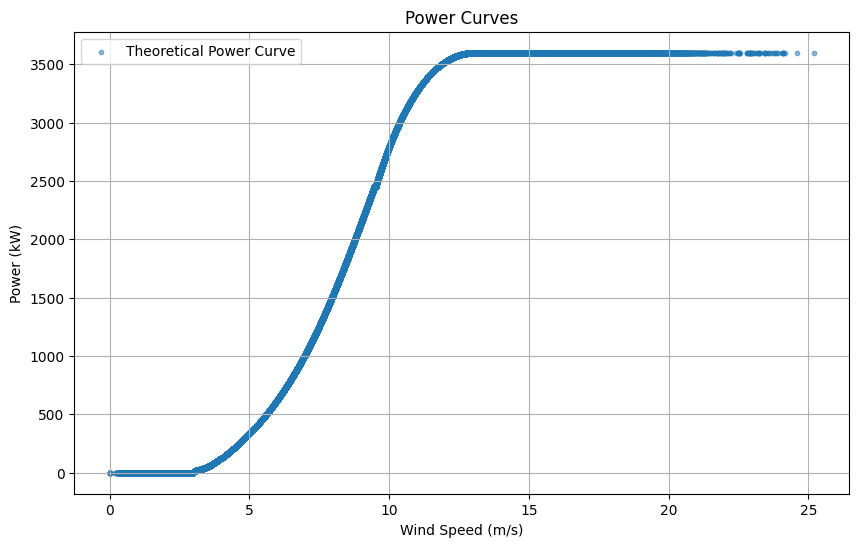

In [ ]:
import matplotlib.pyplot as plt

# Plot the power curves
plt.figure(figsize=(10, 6))
plt.scatter(df['Wind Speed (m/s)'], df['Theoretical_Power_Curve (KWh)'], s=10, alpha=0.5, label='Theoretical Power Curve')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.title('Power Curves')
plt.legend()
plt.grid(True)
plt.show()

**Evaluate the cut-in speed and rated velocity:**

In [ ]:
# Determine the cut-in speed based on theoretical power curve
cut_in_speed = df[df['Theoretical_Power_Curve (KWh)'] > 0]['Wind Speed (m/s)'].min()
cut_in_speed = round(cut_in_speed, 1)
# Filter data based on this cut-in speed
filtered_data = df[df['Wind Speed (m/s)'] >= cut_in_speed]

# Determine the maximum power output
max_power = df['LV ActivePower (kW)'].max()

# Determine the least wind speed at which the maximum power is reached
rated_velocity = df[df['LV ActivePower (kW)'] == max_power]['Wind Speed (m/s)'].min()
rated_velocity = round(rated_velocity,1 )
print("The cut-in speed is " + str(cut_in_speed))
print("The rated velocity is " + str(rated_velocity))

The cut-in speed is 3.0
The rated velocity is 17.9


we will use thses numbers later

# Plot the Actual Power Curve

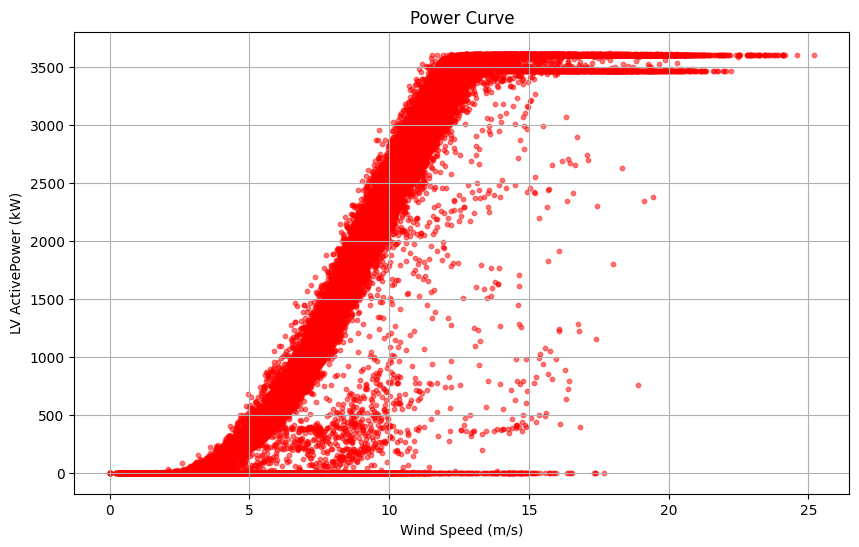

In [ ]:
import matplotlib.pyplot as plt

# Plot the power curve
plt.figure(figsize=(10, 6))
plt.scatter(df['Wind Speed (m/s)'], df['LV ActivePower (kW)'],color='red', s=10, alpha=0.5)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('LV ActivePower (kW)')
plt.title('Power Curve')
plt.grid(True)
plt.show()

# Add Day/Night feature
We do not know the specific location of the turbine to determine the Sunset/Sunrise time, **But...** form the wind atlas of [Turkey](https://globalwindatlas.info/en/area/Turkey), high Wind Speeds (>10m/s) occurs mostly at the west coast at [izmir](https://globalwindatlas.info/en/area/Turkey/Izmir)


In [ ]:
!pip install astral pytz

In [ ]:
from astral import LocationInfo
from astral.sun import sun
import pytz

location = LocationInfo("Izmir", "Turkey", "Europe/Istanbul", 38.4192, 27.1287)
def is_day_or_night(dt):

    s = sun(location.observer, date=dt)
    sunrise = s['sunrise']
    sunset = s['sunset']
    dt = dt.tz_localize('Europe/Istanbul')
    if sunrise < dt < sunset:
            return 0 # Day
    else:
            return 1 # Night.
df['Day/Night'] = df['Date/Time'].apply(is_day_or_night)
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Week,Month,Hour,Season,Day/Night
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,1,1,0,Winter,1
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,1,1,0,Winter,1
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,1,1,0,Winter,1
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,1,1,0,Winter,1
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,1,1,0,Winter,1


# Add Temperature feature
Since we have date/time & approximate location, why not making Temperature column?, Since air density is a variable
and there's an invesrse relation between air density and temperature
$$
P_{\text{turbine}} = \frac{1}{2} \rho A v^3
$$

$$
\rho \alpha \frac{1}{T}
$$

In [ ]:
!pip install meteostat

In [ ]:
import pandas as pd
from datetime import datetime
from meteostat import Point, Hourly

df_1 = pd.read_csv("/kaggle/input/wind-turbine-scada-dataset/T1.csv")
df_1['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%d %m %Y %H:%M')

# Define the location and time period
location = Point(38.4192, 27.1287)  # Coordinates for Izmir, Turkey
start = df_1['Date/Time'].min()
end = df_1['Date/Time'].max()
# Fetch historical weather data for the entire period
data_hourly = Hourly(location, start, end)
data_hourly = data_hourly.fetch()

# Ensure the index is a DatetimeIndex and remove timezone information
data_hourly.index = data_hourly.index.tz_localize(None)

# Resample the hourly data to 10-minute intervals using forward fill
data_10min = data_hourly.resample('10T').ffill().reset_index()

# Select relevant columns and rename them to match the original dataset format
weather_df = data_10min[['time', 'temp']]
weather_df = weather_df.rename(columns={'time': 'Date/Time', 'temp': 'Temperature (°C)'})

# Convert Date/Time to match the format in weather_df
weather_df['Date/Time'] = pd.to_datetime(weather_df['Date/Time'])

# Merge with the existing dataset
df = pd.merge(df, weather_df, on='Date/Time', how='left')
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Week,Month,Hour,Season,Day/Night,Temperature (°C)
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,1,1,0,Winter,1,2.0
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,1,1,0,Winter,1,2.0
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,1,1,0,Winter,1,2.0
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,1,1,0,Winter,1,2.0
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,1,1,0,Winter,1,2.0


In [ ]:
df['Temperature (°C)'].isna().sum()

17

In [ ]:
df['Temperature (°C)'] = df['Temperature (°C)'].interpolate()

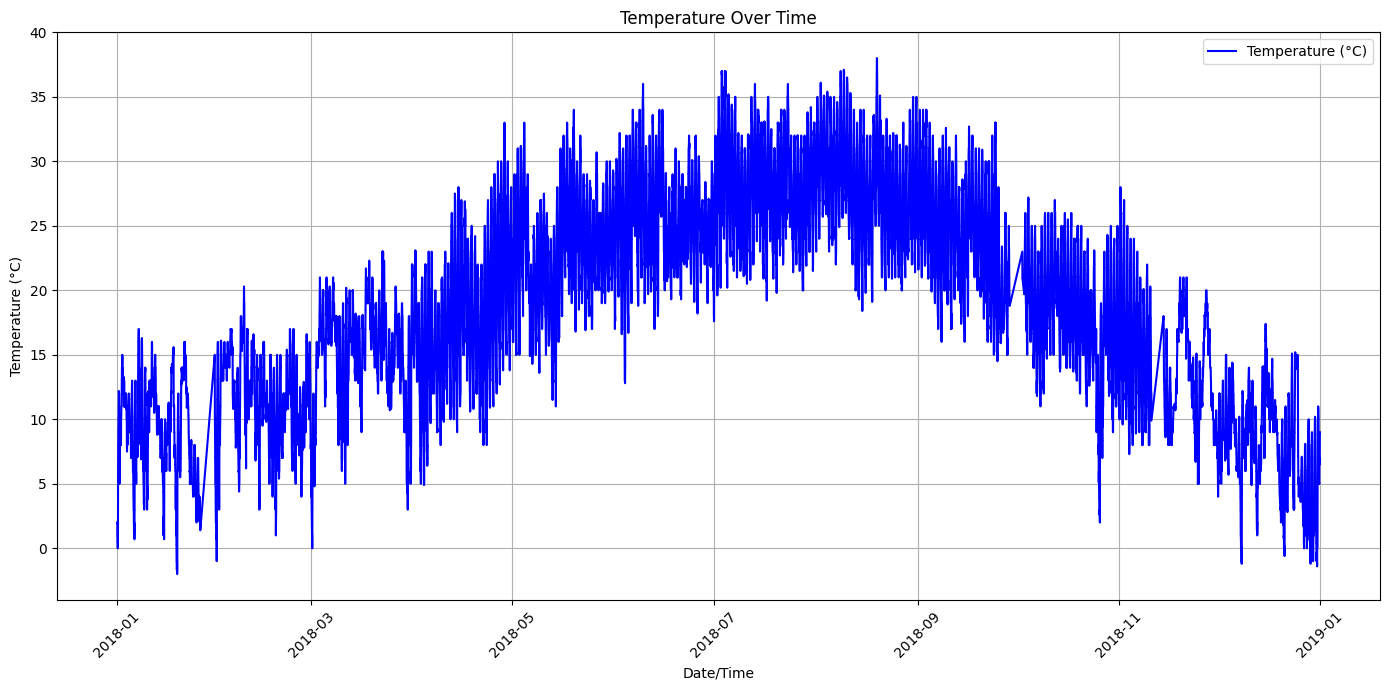

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df['Date/Time'], df['Temperature (°C)'], label='Temperature (°C)', color='b')

plt.xlabel('Date/Time')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


**We have Wind Direction column, to create what?:**
- "Effective Theoretical Power(kWh)": to determine ideal power we make use of at every wind direction

but first we have to discover if there is a yaw system, at this case the wind direction would not be relevent to us
        
# Determine Yaw system existance

**Algorithm for finding a yaw system**
1. Discover if our data covers all wind directions to be able to test it

2. plot a scatter plot that draws a relation between power and wind direction, to determine if yaw system exists, if so the power output would be always high whatever the wind direction
3. plot a scatter plot that draws a relation between power and wind speed, to make sure if we have optimal wind direction where wind speed is always high or variating wind speed with different wind directions



A box plot can substitute for this

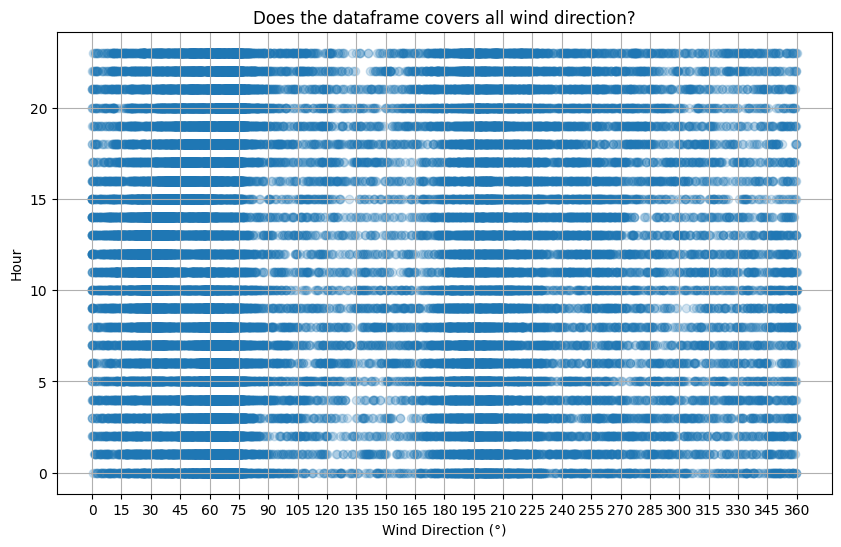

In [ ]:
# Plot wind direcion vs wind power
plt.figure(figsize=(10, 6))
plt.scatter(df['Wind Direction (°)'], df['Hour'], alpha=0.2)
plt.title('Does the dataframe covers all wind direction?')
plt.xlabel('Wind Direction (°)')
plt.xticks(list(range(0, 365, 15)))
plt.ylabel('Hour')
plt.grid(True)
plt.show()

The answer is: **Nearly Yes**

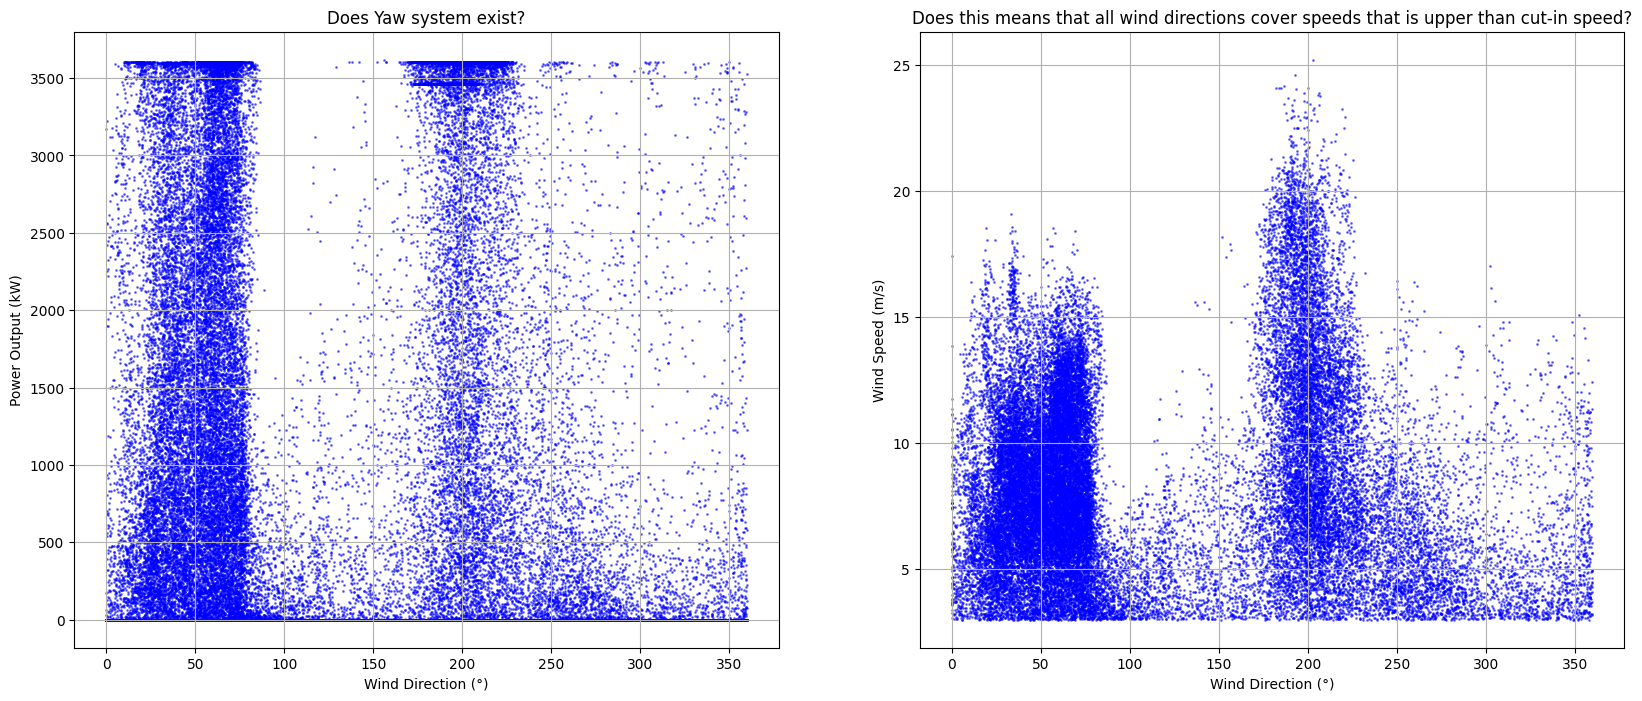

In [ ]:
import matplotlib.pyplot as plt

filtered_df = df[df['Wind Speed (m/s)'] > cut_in_speed]

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

axes[0].scatter(df['Wind Direction (°)'], df['LV ActivePower (kW)'], alpha=0.5, c='blue', s=1)
axes[0].set_title('Does Yaw system exist?')
axes[0].set_xlabel('Wind Direction (°)')
axes[0].set_ylabel('Power Output (kW)')
axes[0].grid(True)

axes[1].scatter(filtered_df['Wind Direction (°)'], filtered_df['Wind Speed (m/s)'], alpha=0.5, c='blue', s=1)
axes[1].set_title('Does this means that all wind directions cover speeds that is upper than cut-in speed?')
axes[1].set_xlabel('Wind Direction (°)')
axes[1].set_ylabel('Wind Speed (m/s)')
axes[1].grid(True)

plt.show()

Notes from the figures:

-  There are no high speeds at some wind directions, but our data covers all wind directions. This is scientifically possible due to various meteorological and geographical factors.
- The stakeholder uses the wind turbine at the optimal angle, as both graphs are nearly the same.
- Determining the existence of a yaw system would be more challenging. Why? The yaw system is used to keep the wind turbine direction parallel to the actual wind direction. From the right graph, we have high wind speeds only at ranges (0°, 70°) and (190°, 210°). So if a yaw system existed, it would operate the yaw mechanism rarely, i.e., we would not monitor its operation.

**But...** We already know the wind directions with the highest wind speeds, so we can develop a feature that measures Effective Theoretical Power.


**Algorithm for making Effective Theoretical Power**
1. Determine the optimal wind direction, from the graph it's 60 and 210
        
2. Determine Deviation from Optimal Wind Direction:
        - Determine the wind direction deviation from the optimal wind direction
        - Making the deviation from turbine axis divided by 360 to determine deviation percentage
        - Then subtracting this deviation percentage from 1 to get the "usability"
3. Multiply usability with Theoretical Power

In [ ]:
def get_deviation(wind_direction):
    optimal_angles = [60, 210]
    deviations = [min(abs(wind_direction - angle), abs(wind_direction - angle + 360), abs(wind_direction - angle - 360)) for angle in optimal_angles]
    return min(deviations)
df['Effective Theoretical Power(kWh)'] = (100 - ((df['Wind Direction (°)'].apply(get_deviation) / 360) * 100)) * df['Theoretical_Power_Curve (KWh)']
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Week,Month,Hour,Season,Day/Night,Temperature (°C),Effective Theoretical Power(kWh)
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,1,1,0,Winter,1,2.0,35851.134228
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,1,1,0,Winter,1,2.0,43522.711755
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,1,1,0,Winter,1,2.0,32296.507987
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,1,1,0,Winter,1,2.0,42830.260341
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,1,1,0,Winter,1,2.0,41566.071686


# Feature importance

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df = pd.get_dummies(df, ['Season'])
df = df.drop(columns= 'Date/Time')
scaler = StandardScaler()
columns = df.columns

# Fit and transform the data
df = scaler.fit_transform(df)

# Convert the result back to a DataFrame
df = pd.DataFrame(df, columns = columns)

df = pd.get_dummies(df)
y = df['LV ActivePower (kW)']
X = df.drop(columns=['LV ActivePower (kW)'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

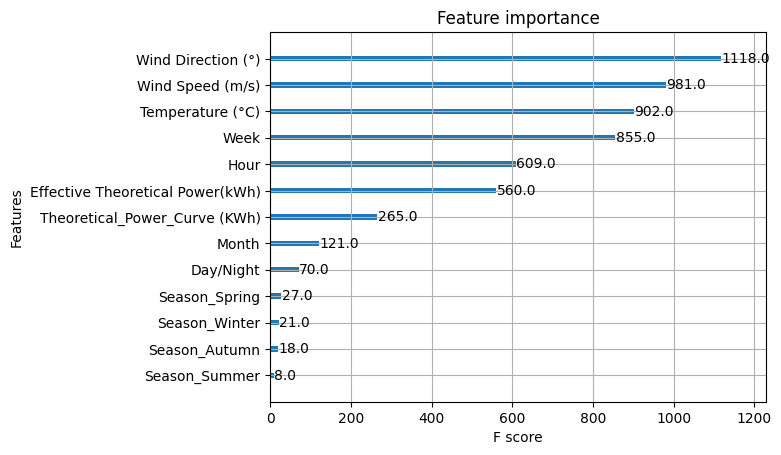

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Train XGBoost model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
# Train XGBoost model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
importances = model.feature_importances_
feature_names = X.columns


# Plot feature importances
xgb.plot_importance(model)
plt.show()


# Models Evaluation

In [ ]:
# this part of code is copied from notebook: https://www.kaggle.com/code/youssifshaabanqzamel/wind-turbine-eda-and-modeling-0-986-r2
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor,XGBRFRegressor
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
model_name=[]
r2score=[]
rmse=[]
models=[
    GradientBoostingRegressor(random_state=42),
    SVR(),
    RandomForestRegressor(random_state=42),
    LinearRegression(),
    ExtraTreesRegressor(random_state=42),
    AdaBoostRegressor(random_state=42),
    DecisionTreeRegressor(random_state=42),
    XGBRegressor(random_state=42),
    XGBRFRegressor(random_state=42),
    CatBoostRegressor(random_state=42,verbose=False)
]

for model in models:
    model.fit(X_train , y_train)
    y_pred = model.predict(X_test)
    model_name.append(model.__class__.__name__)
    r2score.append(str(r2_score( y_test , y_pred ) * 100 ))
    rmse.append(str(mean_squared_error( y_test , y_pred,squared=False )))
    models_df = pd.DataFrame({"Model-Name":model_name, "R2_score": r2score ,'RMSE':rmse})
models_df = models_df.astype({"R2_score": float, "RMSE": float})
models_df.sort_values("R2_score", ascending = False)

,Model-Name,R2_score,RMSE
7,XGBRegressor,97.822617,0.146864
9,CatBoostRegressor,97.754506,0.149143
4,ExtraTreesRegressor,97.490057,0.157681
2,RandomForestRegressor,97.015561,0.171941
6,DecisionTreeRegressor,95.048504,0.221470
0,GradientBoostingRegressor,94.777390,0.227453
8,XGBRFRegressor,94.369156,0.236175
1,SVR,94.089231,0.241974
3,LinearRegression,90.824246,0.301487
5,AdaBoostRegressor,87.603095,0.350432


# Hyperparameters Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
import xgboost as xgb
import numpy as np

# Define custom scoring functions
def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Define the model
model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter distributions for Randomized Search with discrete values
param_distributions = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 
    'colsample_bylevel': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0],
    'n_estimators': [900, 950, 1000],
    'subsample': [0.6, 0.7, 0.8, 0.9]
}

# Define the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=30,
    scoring=make_scorer(rmse_scorer, greater_is_better=False),
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Perform Randomized Search
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print(f"Best parameters: {best_params}")

# Train the best model
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)

# Evaluate the best model on the test set
predictions = best_model.predict(X_test)
rmse = rmse_scorer(y_test, predictions)
r2 = r2_score(y_test, predictions)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters: {'subsample': 0.7, 'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bylevel': 0.8}


In [ ]:
print(f"Root Mean Squared Error (RMSE) of the best model: {rmse}")
print(f"R² score of the best model: {r2}")

Root Mean Squared Error (RMSE) of the best model: 0.13364367560011517
R² score of the best model: 0.9819697542665388


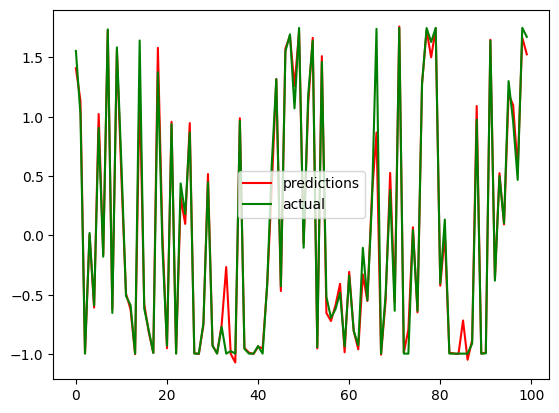

In [ ]:
import matplotlib.pyplot as plt
plt.plot(predictions[:100], 'r', label="predictions")
plt.plot(y_test.to_numpy()[:100], 'g-', label="actual")
plt.legend()
plt.show()

# Summary
* **Model accuracy:** XGBRegressor (R² = 98.2% & RMSE = 0.13)
* Yaw system existencce would be meaningless, as there is high wind speeds at specific angles
* **Crafted features** (Day/Night, Season, Temperature, Day, Hour, Week, Month, Effective Theoretical Power)
* Applied Day/Night with Winter & Summer Solstices to get high accuracy Day/Night timing

**Disclaimer:**  Creating a temperature feature is not a good practice as temperatures vary greatly in different locations. However, [since there are a lot of WTs in izmir](https://tureb.com.tr/eng/lib/uploads/6c479498822929a9.pdf), it will probably help the model, at least until I know the accurate location of the turbines in Turkey, but when it comes to Day/Night the differences is not big when it comes to all possible locations.